### Getting started with Cyclic Ordering with Feature Extraction (COFE) on synthetic data

In [1]:
# Import necessary libraries and modules
import anndata as ad               # For AnnData data container
import COFE as cf                  # For COFE analysis functions
import matplotlib as mp            # For plotting
import numpy as np                 # For numerical operations
from sklearn import metrics        # For evaluation precision-recall performance
from SyntheticData import *        # For generating synthetic datasets

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

### Step 1: Generating Synthetic Data

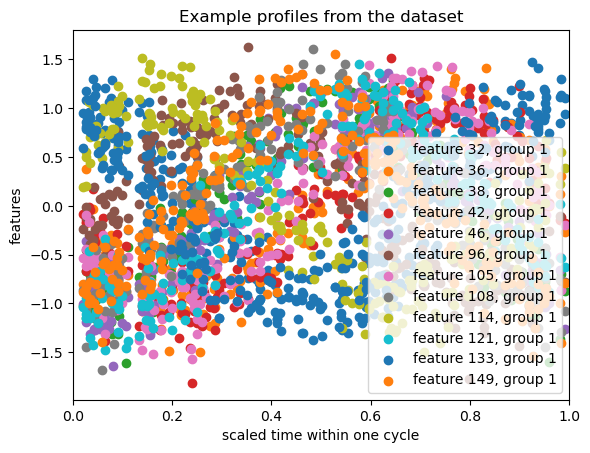

In [2]:
## Define dataset parameters
n_genes = 2000     # Total number of genes/transcripts in the synthetic dataset
n_samples = 200    # Number of samples used for training
n_test = 25        # Number of samples used for testing

# Initialize the data generator with the defined parameters
data = SyntheticData(n_genes, n_samples + n_test)

# Define oscillation frequencies in radians/hour
# Here, we are specifying a single rhythmic group.
data.oscillatory_groups(1)

# Generate the synthetic dataset
# - normal_dist_times=False: Times are uniformly spaced instead of normally distributed
# - rhy_frac=0.1: 10% of genes are rhythmic
X_synthetic, group_info, _ = data.generate_data(normal_dist_times=False, 
                                                    rhy_frac=0.1)

# Extract true sample times (used for validation later)
time = data.t  # True sample times that COFE does not "see" during analysis

# Add noise to the dataset
# st_dev=0.25 adds Gaussian noise with a standard deviation of 0.25
X = data.corrupt(X_synthetic, st_dev=0.25)


# Place the data and metadata within one AnnData object
adata = ad.AnnData(X.T)
adata.obs_names = [f"S{i+1:d}" for i in range(adata.n_obs)]
adata.var_names = [f"g{i+1:d}" for i in range(adata.n_vars)]
adata.obs["time"] = data.t * 24.0
adata.uns["period"] = 24.0
adata.var["rhythmic"] = np.isin(np.arange(adata.n_vars), group_info[1])
## Split the dataset into training and testing sets
adata.obs["train"] = [True] * n_samples + [False] * n_test

# Visualize the generated dataset
# group_info provides labels for rhythmic and arrhythmic genes
data.plot_X(X, group_info, [(1, 12)])

### Step 2: Data Preprocessing

In [3]:
# Standardize the dataset for analysis
adata = cf.preprocess_data(adata, scale=True)

# Check the true labels for rhythmic and arrhythmic genes
rhythmic_genes = [f"g{i+1:d}" for i in group_info[1]]    # Indices of truly rhythmic genes
arrhythmic_genes = [f"g{i+1:d}" for i in group_info[0]]  # Indices of truly arrhythmic genes

### Step 3: Running COFE Analysis

In [4]:
# Define candidate sparsity parameter values
s_choices = np.linspace(1, 30, 15)  # Range of sparsity parameters to evaluate

# Perform cross-validation to train the model
# - K=5: Number of folds for cross-validation
# - restarts=5: Number of restarts to ensure robustness
# - ncores=-1: Use all available CPU cores for parallel processing
# - repeats=3: Repeat cross-validation for stability
adata = cf.cross_validate(adata, s_choices=s_choices, K=5, restarts=5, ncores=-1, repeats=3, seed=0)

# Generate phase predictions for training data
adata = cf.estimate_phase(adata)

### Step 4: Visualizing Results

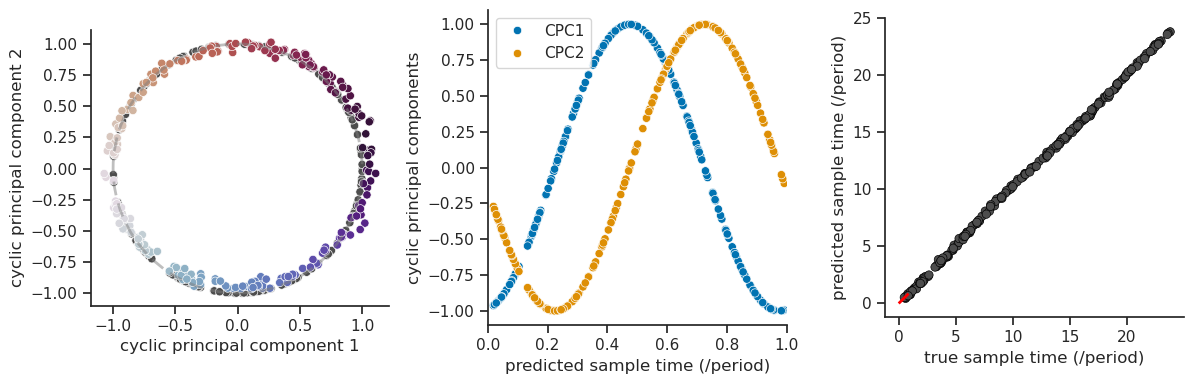

In [5]:
## Plot circular ordering of training data
# - period=1: Period of the rhythms on which true sample times are defined
cf.plot_circular_ordering(
    adata, figsize=(12, 4)
)

### Step 5: Evaluating Temporal Reordering Performance

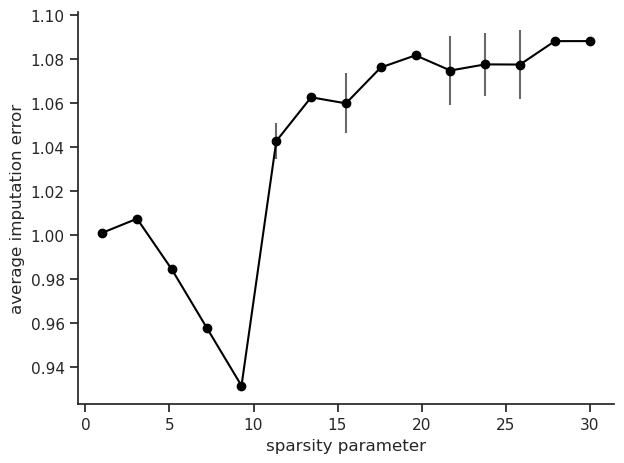

In [6]:
## Plot cross-validation results to find the optimal sparsity parameter
cf.plot_cv_run(adata)

In [7]:
# Phase prediction accuracy (as a fraction of 24 hours)
adata = cf.estimate_phase(adata, train=True)
train_mape = adata.uns["scpca"]["MAPE"]  # Training data accuracy
adata = cf.estimate_phase(adata, train=False)
test_mape = adata.uns["scpca"]["MAPE"]    # Testing data accuracy
print(f"Training MAPE: {train_mape:1.4f}")
print(f"Testing MAPE: {test_mape:1.4f}")

Training MAPE: 0.0046
Testing MAPE: 0.0039


### Step 6: Extracting Biomarkers and Evaluating Its Accuracy

In [8]:
## Display the list of predicted rhythmic genes (biomarkers)
markers = cf.print_markers(adata)

In [9]:
# Performance of rhythmic feature identification using precision and recall
truth = [i in rhythmic_genes for i in adata.var_names]
prediction = [i in markers for i in adata.var_names]
print(f"Precision: {metrics.precision_score(truth, prediction):1.2f}, " 
       f"Recall: {metrics.recall_score(truth, prediction):1.2f}, " 
       f"Matthews correlation coefficient: {metrics.matthews_corrcoef(truth, prediction):1.2f}")

Precision: 1.00, Recall: 0.97, Matthews correlation coefficient: 0.98


In [10]:
group_info[1]

[31,
 35,
 37,
 41,
 45,
 95,
 104,
 107,
 113,
 120,
 132,
 148,
 149,
 153,
 157,
 162,
 170,
 172,
 186,
 189,
 194,
 196,
 204,
 213,
 217,
 234,
 238,
 240,
 245,
 262,
 277,
 291,
 305,
 306,
 313,
 316,
 319,
 353,
 366,
 367,
 374,
 382,
 394,
 406,
 425,
 427,
 437,
 438,
 458,
 478,
 481,
 509,
 521,
 555,
 557,
 558,
 562,
 563,
 566,
 594,
 599,
 603,
 605,
 618,
 623,
 638,
 650,
 680,
 689,
 702,
 735,
 745,
 748,
 751,
 754,
 762,
 770,
 775,
 811,
 836,
 849,
 857,
 890,
 893,
 899,
 908,
 913,
 922,
 939,
 940,
 941,
 967,
 975,
 992,
 997,
 1012,
 1013,
 1014,
 1017,
 1018,
 1021,
 1028,
 1043,
 1048,
 1050,
 1068,
 1074,
 1076,
 1078,
 1081,
 1084,
 1086,
 1087,
 1090,
 1099,
 1126,
 1128,
 1131,
 1144,
 1146,
 1167,
 1168,
 1177,
 1192,
 1196,
 1198,
 1208,
 1237,
 1278,
 1294,
 1295,
 1299,
 1306,
 1320,
 1326,
 1332,
 1339,
 1372,
 1374,
 1382,
 1408,
 1409,
 1416,
 1423,
 1435,
 1445,
 1468,
 1486,
 1489,
 1490,
 1492,
 1502,
 1503,
 1509,
 1514,
 1515,
 1543,
 1

### Exploring COFE Functions

In [11]:
# Use ? to get detailed documentation for any COFE function
# For example, to learn about the cross_validate function:
?cf.cross_validate

Signature:
cf.cross_validate(
    adata,
    s_choices,
    scale_by_features=False,
    K=5,
    repeats=3,
    restarts=5,
    tol=0.001,
    tol_z=1e-06,
    max_iter=400,
    ncores=None,
    seed=None,
)
Docstring:
Calculate the optimal choice of sparsity threshold 's' and the
cyclic ordering for the best 's'

Parameters
----------
adata : AnnData object
    with preprocessed training data matrix
s_choices : array or list or None
    different values of l1 sparsity threshold to compare. If None
    then directly computes non-sparse solution.
scale_by_features: boolean
    whether to weigh features by their the st. dev. for the random initial
    conditions each restart, by default False
K : int, optional
    number of folds used for cross-validation
repeats : int, optional
    the number of different random repetition (of the splits) in
    K-fold cross-validation, by default 3
restarts : int, optional
    the number of random initial conditions to begin alternating
    maximizati